# **Final Project**
**Business Applications of Machine Learning**

This project is guided by professor Samin Aref.

## **Part 0: Loading the libraries and the data**


In this project, we want to develop a statistical model for the mortality rate of lung cancer in the United States.

One of the parts overlooked in many machine learning projects is preprocessing. And a good way to learn it is by solving a lot of examples and test cases. A big part of this project is walking you through preprocessing, making informed decisions using your observations, and exploratory data analysis. Then we use supervised learning methods to construct models to predict the mortality rate of lung cancer using the features provided here.

In [1]:
# data wrangling tools
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", palette=None)

# statistical learning
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Loading data
Load the three csv files as pandas dataframes directly from their URLs.

In [2]:
fulldf = pd.read_csv('https://saref.github.io/teaching/BAIT509/mydata.csv').drop(columns='Unnamed: 0')
data_dict = pd.read_csv('https://saref.github.io/teaching/BAIT509/descriptions.csv')
populationdf = pd.read_csv('https://saref.github.io/teaching/BAIT509/populations.csv').drop(columns='Unnamed: 0')

Data set `mydata.csv` includes most of the data. Explanations on the meaning of each of the columns are included in `descriptions.csv`. Please take your time to understand the three dataframes before proceeding.

## **Part 1: Getting started**

## Data cleaning
In this project, we go through specific data cleaning steps. Please read through the instructions carefully.


### 1.1 Convert `FIPS` column to correct format 
Federal Information Processing Standard or [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) is a categorical variable. It is a code with five digits. The left two digits showing the state and the three right digits showing the county code. We recognize that desipite being a number, FIPS is actually a categorical variable.
First, check the format of the `FIPS` column and convert them to the five digit format with type `np.object_` as seen in the county level section, [here](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt#:~:text=county%2Dlevel%20%20%20%20%20%20place). 

*Hint*: You can use [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) to first convert the type and then use [`str.pad`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.pad.html) to format the values as five digit numbers.

In [3]:
fulldf["FIPS"] = fulldf["FIPS"].apply(str).str.pad(width=5, side='left', fillchar='0')

### 1.2 Check for null values 

Just check for null values and remove columns whenever the percentage of null values is greater than 20. Please briefly justify your choices w.r.t. the columns you have removed.

In [4]:
missing_values_count = fulldf.isnull().sum()
row, column = fulldf.shape
percentage_miss = (missing_values_count/row)*100
print(percentage_miss)



State                   0.000000
AreaName                0.000000
All_Poverty             0.000000
M_Poverty               0.000000
F_Poverty               0.000000
FIPS                    0.000000
Med_Income              0.031908
Med_Income_White        0.063816
Med_Income_Black       38.608807
Med_Income_Nat_Am      52.967454
Med_Income_Asian       56.062540
Med_Income_Hispanic    21.729419
M_With                  0.000000
M_Without               0.000000
F_With                  0.000000
F_Without               0.000000
All_With                0.000000
All_Without             0.000000
Incidence_Rate          0.000000
Avg_Ann_Incidence       0.000000
Recent_Trend            0.000000
Mortality_Rate          0.000000
Avg_Ann_Deaths          0.000000
dtype: float64


From the above summary, `Med_Income_Black`, `Med_Income_Nat_Am`, `Med_Income_Asian` and `Med_Income_Hispanic` columns have more than 20% missing value, which will be removed. In addition, `Med_Income_White` is also a column that similar to the colums that being removed as they are describing the Med_Income for different enthnicities, so `Med_Income_White` will also be removed as well.

In [5]:
fulldf = fulldf.drop(columns=['Med_Income_White', 'Med_Income_Black', 'Med_Income_Nat_Am', 'Med_Income_Asian','Med_Income_Hispanic'])

### 1.3 Check the format of columns
Report the format of each column. List the columns that are in an unexpected format and state why you think that is the case.

*Hint*: You can do this by either inspecting the dataframe or by writing a code snippet that tells you what cells cannot be reformatted to the correct format. The Titatinc Jupyter file that we covered in class may also give you some useful ideas.

In [6]:
fulldf.dtypes

State                 object
AreaName              object
All_Poverty            int64
M_Poverty              int64
F_Poverty              int64
FIPS                  object
Med_Income           float64
M_With                 int64
M_Without              int64
F_With                 int64
F_Without              int64
All_With               int64
All_Without            int64
Incidence_Rate        object
Avg_Ann_Incidence     object
Recent_Trend          object
Mortality_Rate        object
Avg_Ann_Deaths        object
dtype: object

`Incidence_Rate`, `Avg_Ann_Incidence`, `Mortality_Rate`, `Avg_Ann_Deaths` should be in numerical value, but now is in "object" format. As these columns contain the non-numerical value * to stand for fewer that 16 reported cases and also some "__" value due to Inconsistent Data Entry.

### 1.4 Merge the population data to the main dataframe [5 Marks]
You already know about FIPS. You can use the state and county columns in this dataset to construct a FIPS column in the population dataframe in the same format as the main dataframe. Then merge the population data to the main dataframe. It is up to you to decide the type of merge and whether it is done properly.

In [7]:
#combin the FIPS column in the population dataset
populationdf["STATE"] = populationdf["STATE"].apply(str).str.pad(width=2, side='left', fillchar='0')
populationdf["COUNTY"] = populationdf["COUNTY"].apply(str).str.pad(width=3, side='left', fillchar='0')
populationdf['FIPS'] = populationdf["STATE"] + populationdf["COUNTY"]

In [8]:
#merge the datasets
fulldf = fulldf.merge(populationdf, how='left', on='FIPS').drop(columns=['STATE','COUNTY'])

### 1.5 Cleaning the output (response) column `Mortality_Rate`
Using the file `descriptions.csv`, explain what the non-numerical values of `Mortality_Rate` mean. 

Then, it is decision making time, we have to decide whether to remove the non-numerical values from `Mortality_Rate` or to assign a specific numerical value to them. This decision is based on you inferring if the non-numerical values were caused by error in data gathering or not. 

Note that if the observations are valid and are deleted, we are adding a bias to the model.

*Hint*: To get the full mark for this part, conduct multiple relevant exploratory data analyses. Then use them to support your decision on removing or modifying the non-numerical values. Your choice results in full mark if the supporting analysis and arguments are deemed adequate and convincing.

In [9]:
fulldf_missing = fulldf[fulldf['Mortality_Rate']=='*']
fulldf_nomissing = fulldf[fulldf['Mortality_Rate']!='*']

In [10]:
print("Rows in original dataset: %d \n" % fulldf.shape[0])
print("Rows with * in Mortality_Rate column: %d" % fulldf_missing.shape[0])

Rows in original dataset: 3134 

Rows with * in Mortality_Rate column: 325


Text(0.5, 1.0, 'population distirbution of state with non-numerical Mortality_Rate value')

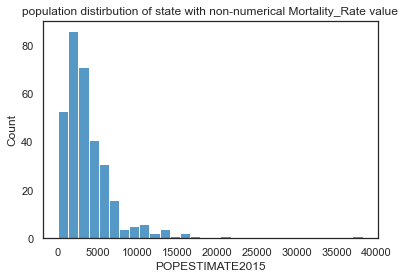

In [11]:
#check the population distribution of the Mortality_Rate non-numerical value
plot = sns.histplot(data=fulldf_missing, x="POPESTIMATE2015", bins = 30)
plt.title('population distirbution of state with non-numerical Mortality_Rate value')

Population distirbution of state with population less than 5000


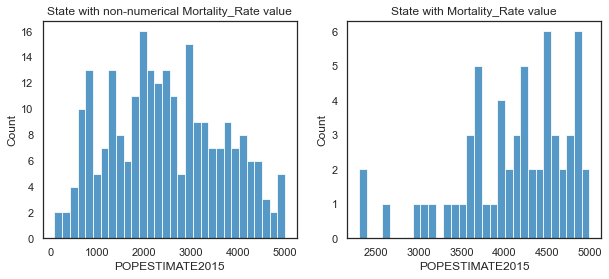

In [12]:
#compare the population distribution of state without and with Mortality_Rate
print("Population distirbution of state with population less than 5000")
fig, ax =plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fulldf_missing[fulldf_missing['POPESTIMATE2015']<= 5000], x="POPESTIMATE2015", bins = 30, ax=ax[0]).set(title='State with non-numerical Mortality_Rate value')
sns.histplot(data=fulldf_nomissing[fulldf_nomissing['POPESTIMATE2015']<= 5000], x="POPESTIMATE2015", bins = 30, ax=ax[1]).set(title='State with Mortality_Rate value')
plt.show()

Text(0.5, 1.0, 'Distribution of Mortality_Rate with numerical value')

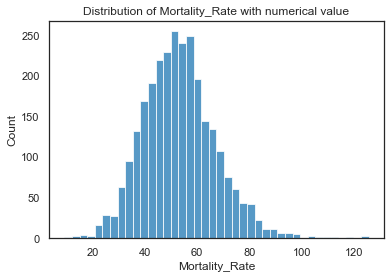

In [13]:
#population distribution of state with Mortality_Rate
fulldf_nomissing = fulldf_nomissing.astype({"Mortality_Rate": 'float64'})
plot = sns.histplot(data=fulldf_nomissing, x="Mortality_Rate", bins = 40)
plt.title('Distribution of Mortality_Rate with numerical value')

In [14]:
fulldf['POPESTIMATE2015'].describe().round()

count        3134.0
mean       102522.0
std        329598.0
min            89.0
25%         11042.0
50%         25764.0
75%         67765.0
max      10170292.0
Name: POPESTIMATE2015, dtype: float64

In [15]:
fulldf_nomissing['Mortality_Rate'].describe()

count    2809.000000
mean       53.188537
std        14.042077
min         9.200000
25%        43.700000
50%        52.600000
75%        61.200000
max       125.600000
Name: Mortality_Rate, dtype: float64

In [16]:
fulldf_nomissing['POPESTIMATE2015'].describe().round()

count        2809.0
mean       113930.0
std        346339.0
min          2302.0
25%         14844.0
50%         31183.0
75%         79161.0
max      10170292.0
Name: POPESTIMATE2015, dtype: float64

The non-numerical value * in the `Mortality_Rate` column illustrates that the state has less than 16 lung cancer death cases reported, which indicating that there might not be sufficient data to calculate the mortality rate or the mortality rate is so low that we might not be able gather. From the above exploratory analysis, the non-numerical value in `Mortality_Rate` column account for about 10% of the original dataset and from its population distirbution plot, we can found that majority of the state with non-numerical value in `Mortality_Rate` column have smaller population compared to other state. There might be two possible reasons that we can not capture the data. One is that the mortality rate is very low in the state with small populations such that there are less than 16 cases reported. The other one is that the state population is so small that it is hard to caputure more than 16 cases. From the `Distribution of Mortality_Rate with numerical value` plot, we can found that the mortality rate of the current available data show a gaussian distribution with center around 50. And from the `Population distirbution of state with population less than 5000` plots, we can found that as population increase, the mortality rate data become more available and the number of state with non-numerical value decrease. Both plots indicate that the reason of non-numerical value is more likely to be the population is too small to get 16 cases reported. As a result, it is more reasonable to drop the rows with non-numerical value in `Mortality_Rate` column as there might not be sufficient data from the small population state to calculate the mortality rate.


In [17]:
#drop the row with Mortality_Rate == *
fulldf = fulldf.drop(fulldf[fulldf['Mortality_Rate'] == "*"].index)
fulldf.shape

(2809, 19)

### 1.6 Reformat the rest of the columns specified in 1.3 to numerical 
In each column reformat all the cells that you can. 

*Hint*: You can keep the cells that you cannot reformat until you decide if you want to use the specific column in the model. This is because you want to lose as least data as possible. So you can drop the associated rows if you want to use the column and keep them if the specific column is not used.

In [18]:
fulldf.dtypes

State                 object
AreaName              object
All_Poverty            int64
M_Poverty              int64
F_Poverty              int64
FIPS                  object
Med_Income           float64
M_With                 int64
M_Without              int64
F_With                 int64
F_Without              int64
All_With               int64
All_Without            int64
Incidence_Rate        object
Avg_Ann_Incidence     object
Recent_Trend          object
Mortality_Rate        object
Avg_Ann_Deaths        object
POPESTIMATE2015        int64
dtype: object

In [19]:
#clean the Avg_Ann_Deaths column, some inconsistent data entry
fulldf['Avg_Ann_Deaths'] = fulldf['Avg_Ann_Deaths'].replace(',','', regex=True)

In [20]:
#clean 'Incidence_Rate' cloumn
fulldf['Incidence_Rate'] = fulldf['Incidence_Rate' ].replace('_','', regex=True)
fulldf['Incidence_Rate'] = fulldf['Incidence_Rate' ].replace('__','', regex=True)
fulldf['Incidence_Rate'] = fulldf['Incidence_Rate' ].replace('#','', regex=True)
#There are 5 states with less than 16 incidence cases reported but more than 16 death cases report, which is inconsistent. I will drop these states.
fulldf = fulldf.drop(fulldf[fulldf['Incidence_Rate'] == "*"].index)


In [21]:
#clean 'Avg_Ann_Incidence' columns
fulldf['Avg_Ann_Incidence' ] = fulldf['Avg_Ann_Incidence'].replace('_','', regex=True)
fulldf['Avg_Ann_Incidence' ] = fulldf['Avg_Ann_Incidence'].replace('__','', regex=True)
fulldf['Avg_Ann_Incidence' ] = fulldf['Avg_Ann_Incidence'].replace('3 or fewer',3, regex=True) #change '3 or fewer' to 3 might introduce some bias, but would not be a lot here, aim to keep data in numerical value

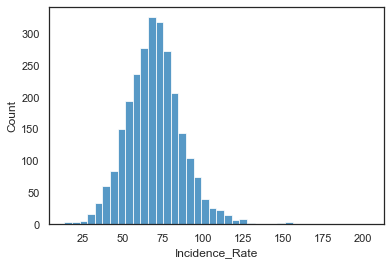

In [22]:
fullnotnull = fulldf [fulldf['Incidence_Rate'] != '']
fullnotnull = fullnotnull.astype({"Incidence_Rate": 'float64'})
plot = sns.histplot(data=fullnotnull, x="Incidence_Rate", bins = 40) # show Gaussian distribution
#fullnull.shape  #(163, 19) about 6% of the available data, decide to drop it to avoid bias for the model
fulldf = fulldf.drop(fulldf[fulldf['Incidence_Rate'] == ''].index)
#Drop the row with * in trend
fulldf = fulldf.drop(fulldf[fulldf['Recent_Trend'] == '*'].index)

In [23]:
#change the datatype to numeric
fulldf = fulldf.astype({"Mortality_Rate": "float64"
                    , "Avg_Ann_Deaths": "float64"
                    , "Incidence_Rate": "float64"
                    , "Avg_Ann_Incidence": "float64"
                    })

### 1.7 Make the numerical data useful
We know we have many columns of data, some of them are dependent on the populations. As a *Hint*, convert all the raw data to per 100,000 persons rates (divide by population and multiply by 100,000).

In [24]:
columns  = ['All_Poverty','M_Poverty', 'F_Poverty', 'M_With', 'M_Without', 'F_With', 'F_Without','All_With', 'All_Without','Avg_Ann_Incidence','Avg_Ann_Deaths']
for a in columns:
    fulldf[a] = fulldf[a]/fulldf['POPESTIMATE2015']*100000
fulldf = fulldf.round()

In [25]:
#split the 'Recent_Trend' column into three dummy variable columns
fulldf = pd.get_dummies(fulldf, columns=['Recent_Trend'])

## **Part 2: Exploratory analysis**

### 2.1 Visualizing different features 
Here, show different feature and how they change with respect to each other.
*Hint*: A good function to use here is `sns.pairplot`. Remember to have the plots labeled properly so that they are self explanatory.


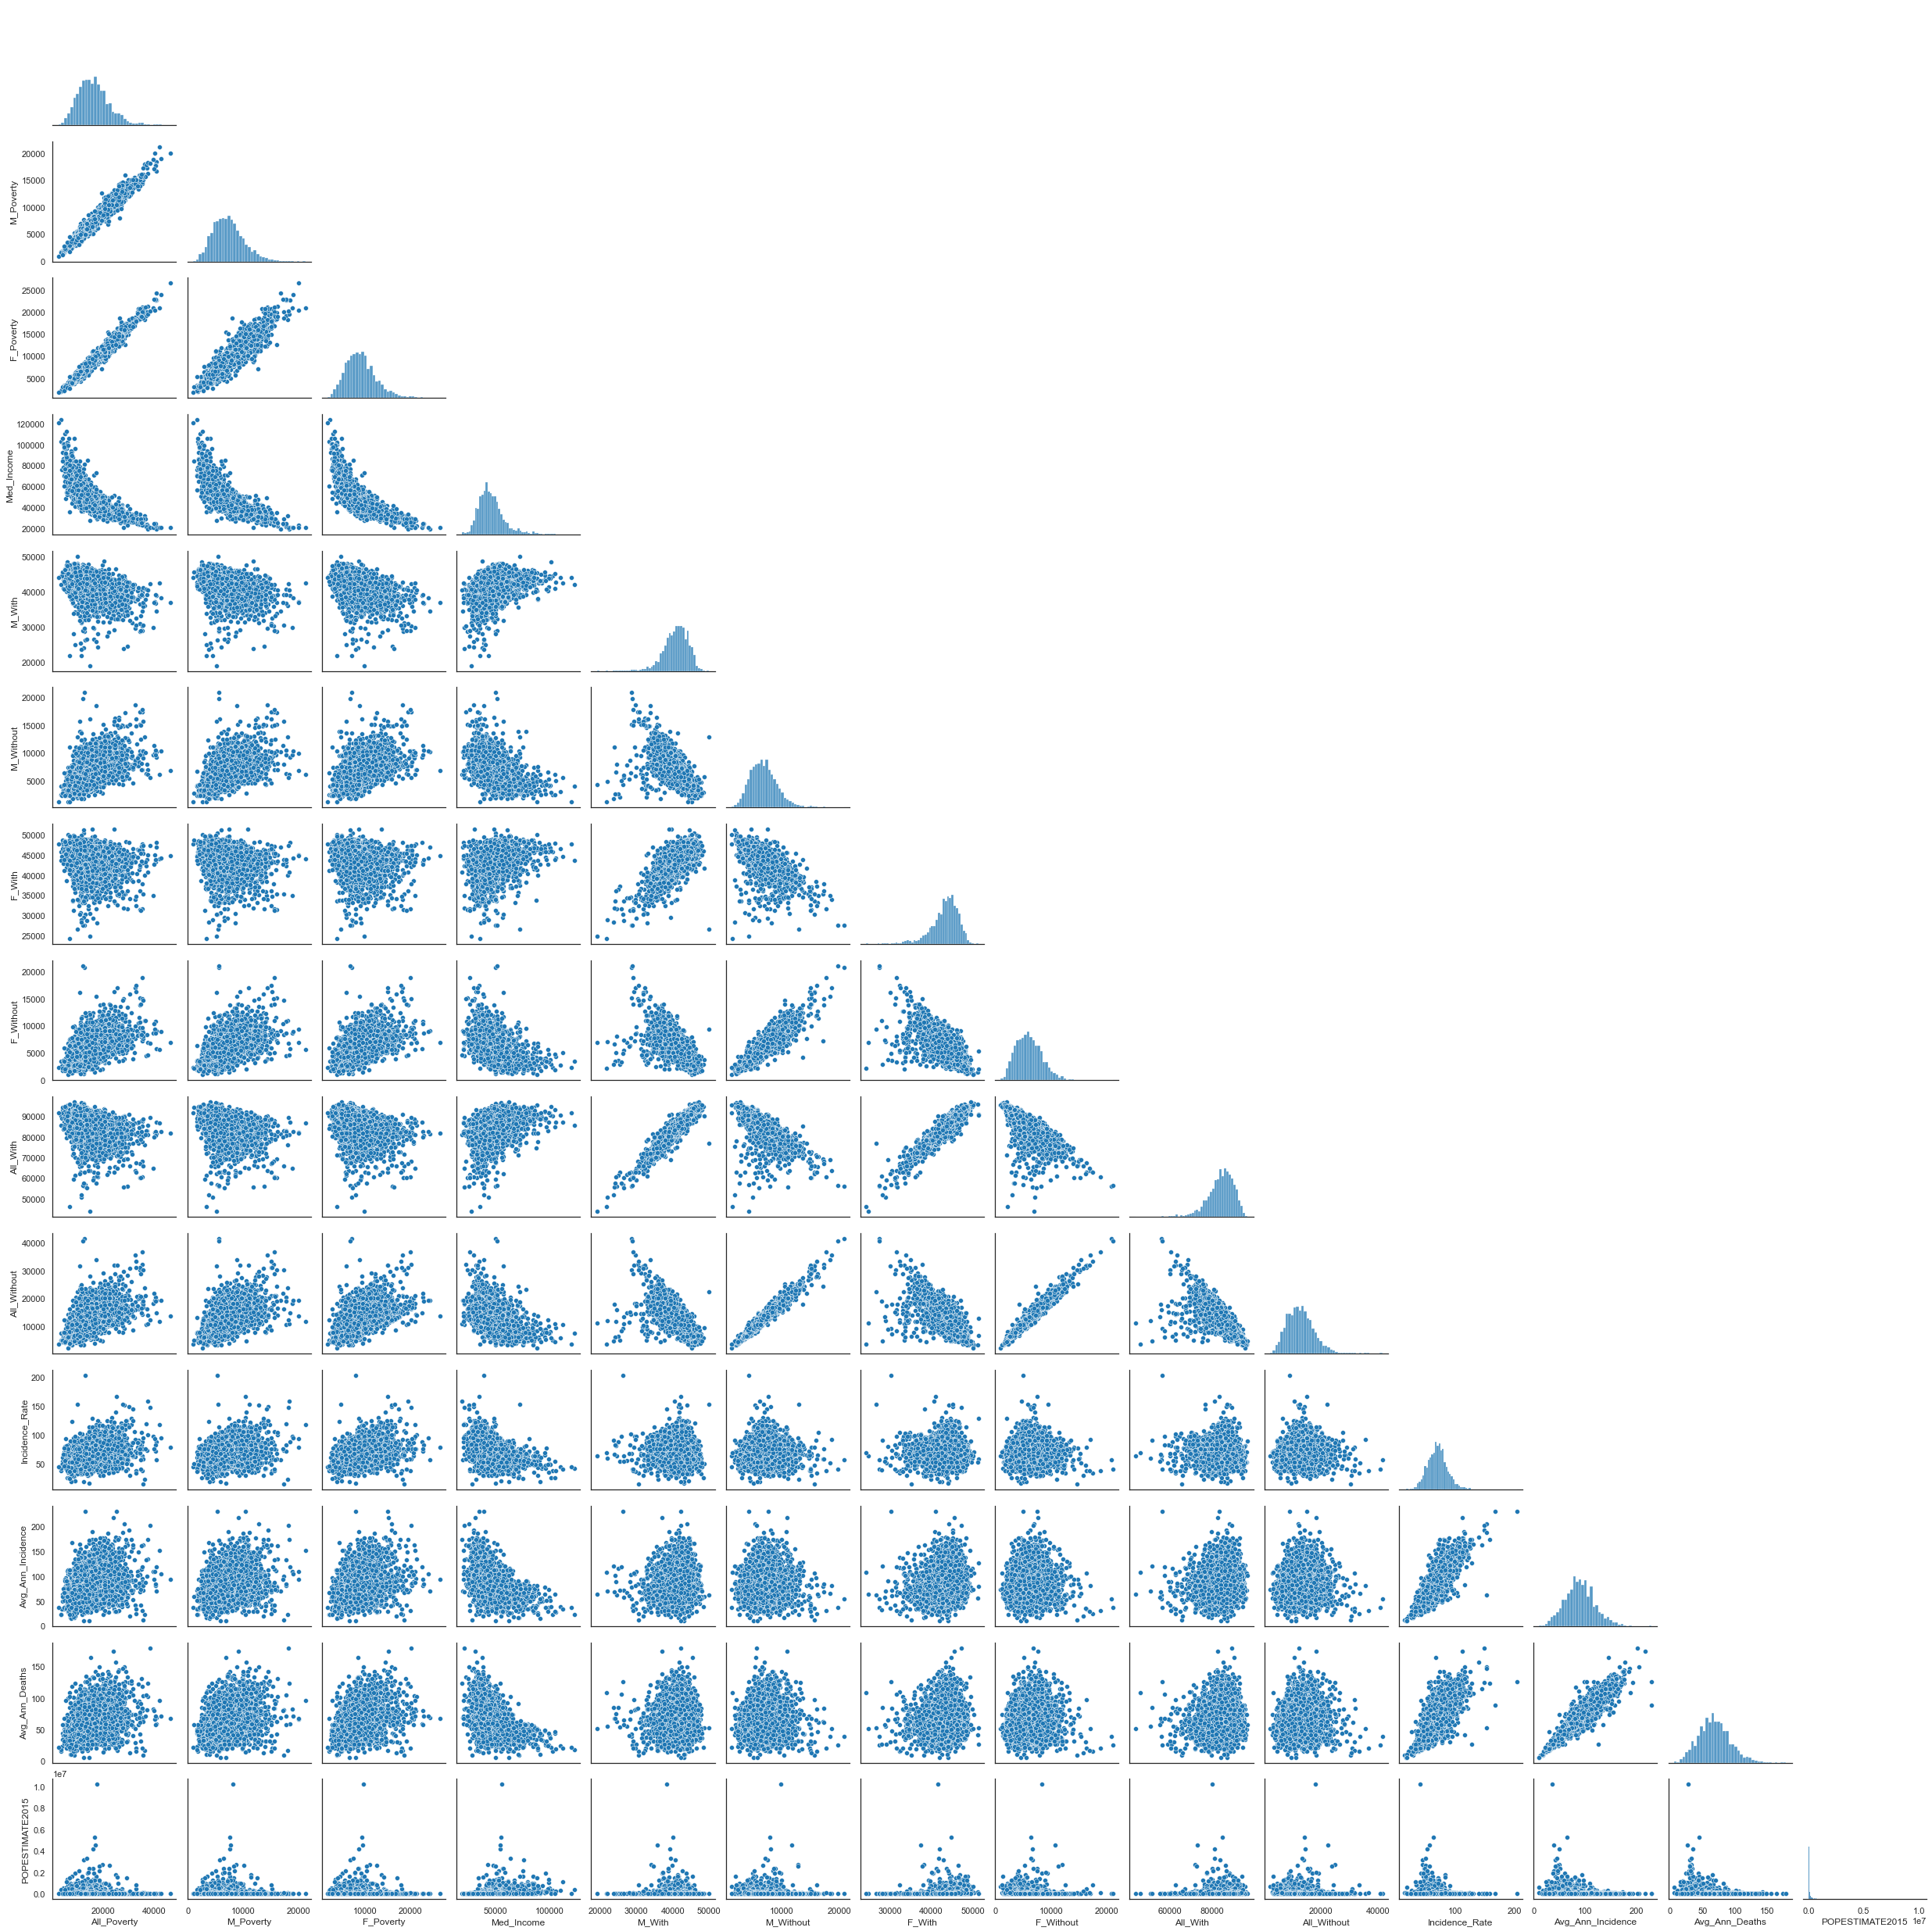

In [26]:
feature = ['All_Poverty','M_Poverty', 'F_Poverty', 'Med_Income' ,'M_With', 'M_Without', 'F_With', 'F_Without','All_With', 'All_Without','Incidence_Rate','Avg_Ann_Incidence', 'Avg_Ann_Deaths', 'POPESTIMATE2015']
sns.pairplot(
    fulldf[feature],
    corner=True
)

In [27]:
fulldf.corr()

,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015,Recent_Trend_falling,Recent_Trend_rising,Recent_Trend_stable
All_Poverty,1.000000,0.977544,0.984624,-0.785962,-0.403726,0.548689,-0.206554,0.536689,-0.327770,0.555527,0.330761,0.286220,0.388453,0.321150,-0.083320,-0.070055,0.015301,0.058055
M_Poverty,0.977544,1.000000,0.925702,-0.760947,-0.366119,0.549406,-0.219639,0.513017,-0.314149,0.543762,0.308217,0.268441,0.362201,0.300414,-0.077604,-0.065672,0.019735,0.052143
F_Poverty,0.984624,0.925702,1.000000,-0.779984,-0.421177,0.529443,-0.188683,0.538069,-0.327917,0.546396,0.338202,0.291228,0.397011,0.327422,-0.085224,-0.071306,0.011101,0.060984
Med_Income,-0.785962,-0.760947,-0.779984,1.000000,0.346016,-0.443054,0.229984,-0.441121,0.308620,-0.452550,-0.383509,-0.505419,-0.446540,-0.538079,0.258945,0.160799,-0.015750,-0.141449
M_With,-0.403726,-0.366119,-0.421177,0.346016,1.000000,-0.658666,0.755415,-0.662754,0.939409,-0.676351,-0.067250,0.069754,-0.101289,0.048856,-0.035675,0.013519,0.052308,-0.034578
M_Without,0.548689,0.549406,0.529443,-0.443054,-0.658666,1.000000,-0.636231,0.908586,-0.691299,0.976818,0.047316,0.021230,0.128951,0.069151,-0.009873,-0.027665,-0.026286,0.036601
F_With,-0.206554,-0.219639,-0.188683,0.229984,0.755415,-0.636231,1.000000,-0.686912,0.934262,-0.677266,0.030202,0.130740,-0.024969,0.101559,0.050403,0.055518,0.038147,-0.067274
F_Without,0.536689,0.513017,0.538069,-0.441121,-0.662754,0.908586,-0.686912,1.000000,-0.720038,0.976940,0.045168,0.012180,0.133755,0.066947,-0.032081,-0.044830,-0.024917,0.051832
All_With,-0.327770,-0.314149,-0.327917,0.308620,0.939409,-0.691299,0.934262,-0.720038,1.000000,-0.722391,-0.020799,0.106356,-0.068185,0.079719,0.006955,0.036401,0.048421,-0.054011
All_Without,0.555527,0.543762,0.546396,-0.452550,-0.676351,0.976818,-0.677266,0.976940,-0.722391,1.000000,0.047332,0.017091,0.134463,0.069655,-0.021489,-0.037118,-0.026209,0.045275


### 2.2 Selecting the most important features
In this step, we want to remove the redundant features. 

*Hint*: This can be done by analyzing the correlation between the features and removing the highly correlated features. Remember, throughout the project, write down specific reasons for any desicion you make.

From the pairgraph above, we can observe that `M_Poverty`, `F_Poverty` and `All_Poverty` are highly positive associated with each other and and all three features have similar corrlation coefficient with the response column `Mortality_Rate` so we will only keep the `All_Poverty` feature to represent the total reported below poverty line rate.\
\
Similarly, `M_With`, `F_With` and  `All_With`, `M_Without`, `F_Without` and  `All_Without` have similar correlation pattern. As a result, we will only keep `All_With` and `All_Without`. `All_With` and `All_Without` are also highly correlated with each other with correlation coefficient 0.73, so we will only keep `All_Without` as it has high correlation coefficient with `Mortality_Rate`. \
\
`Avg_Ann_Incidence` and  `Avg_Ann_Deaths` also show strong linear association with each other, which we will only include one of them into our model.\
\
In conclusion, the redundant features that we decided to remove are `M_Poverty`, `F_Poverty`, `M_With`, `F_With` and  `All_With`, `M_Without`, `F_Without`. `Avg_Ann_Incidence` and  `Avg_Ann_Deaths` will be used to test in the modeling stage as they both have high association with `Mortality_Rate`.


In [28]:
#Create transformation using log for all the selected features
fulldf['log_All_Poverty'] = np.log(fulldf['All_Poverty'])
fulldf['log_Mortality_Rate'] = np.log(fulldf['Mortality_Rate'])
fulldf['log_Med_Income'] = np.log(fulldf['Med_Income'])
fulldf['log_All_Without'] = np.log(fulldf['All_Without'])
fulldf['log_Incidence_Rate'] = np.log(fulldf['Incidence_Rate'])
fulldf['log_Avg_Ann_Deaths'] = np.log(fulldf['Avg_Ann_Deaths'])
fulldf['log_POPESTIMATE2015'] = np.log(fulldf['POPESTIMATE2015'])

## **Part 3: Regression Model Construction**

### 3.1 Splitting the dataset 

Split the dataset to three parts: train, validation, and test. You choose the ratios for the three datasets and provide a one-sentence rationale on why you went with such ratios.

*Hint*: You can use the validation set approach from ch5 lab (google colab).

In [52]:
#3-way split of the data to 50%, 25%, 25% as there is not a big dataset, and we need more data for training.
fulldf = fulldf.sample(frac=1).reset_index(drop=True)
fulldf_hold_out=fulldf[int(0.75*len(fulldf)):len(fulldf)] # Separate the last 25% as hold-out data (test data)
fulldf=fulldf[0:int(0.75*len(fulldf))] # Keep the first 75% as training+validation data
np.random.seed(1)
#Randomly selecting 2/3 of the accessible samples as training data (50% of the total samples)
train = np.random.choice(fulldf.shape[0], int(2*fulldf.shape[0]/3), replace=False) 
select = np.in1d(range(fulldf.shape[0]), train)

### 3.2 Model training 
Create three different models, using different features (and optionally nonlinear transformations). The purpose of these models is to predict mortality rate of lung cancer with reasonably high R2 (at least exceeding 70%) using a carefully chosen and justified set of features. Use the visualizations from section 2.1 to inform the feature selection for each model.

***Model1*** \
Include all the selected feature except `Avg_Ann_Incidence`.

In [53]:
#model1
feature1 = [
            'All_Poverty'
            ,'Med_Income'
            ,'All_Without'
            ,'Incidence_Rate'
            #,'Avg_Ann_Incidence'
            ,'Avg_Ann_Deaths'
            ,'POPESTIMATE2015'
            ,'Recent_Trend_falling'
            ,'Recent_Trend_rising'
            ,'Recent_Trend_stable'
            ]
formula = 'Mortality_Rate ~' + "+".join(feature1)
lm1 = smf.ols(formula, data=fulldf[select]).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Mortality_Rate   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     611.0
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:15:53   Log-Likelihood:                -3069.3
No. Observations:                 981   AIC:                             6157.
Df Residuals:                     972   BIC:                             6201.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -8.0542      1.839     -4.380      0.000     -11.663      -4.446
All_Poverty              0.0003   5.35e-05      6.246      0.000       0.000       0.000
Med_Income               0.0002   2.78e-05      5.983      0.000       0.000       0.000
All_Without              0.0002   4.66e-05      5.219      0.000       0.000       0.000
Incidence_Rate           0.4042      0.014     29.806      0.000       0.378       0.431
Avg_Ann_Deaths           0.2841      0.012     23.990      0.000       0.261       0.307
POPESTIMATE2015      -2.977e-07   4.38e-07     -0.679      0.497   -1.16e-06    5.62e-07
Recent_Trend_falling    -2.2073      0.893     -2.473      0.014      -3.959      -0.456
Recent_Trend_rising     -3.2690      1.410     -2.319      0.021      -6.036      -0.502
Recent_Trend_stable     -2.5779      0.735     -3.508      0.000      -4.020      -1.136
==============================================================================
Omnibus:                      128.098   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              532.874
Skew:                          -0.547   Prob(JB):                    1.94e-116
Kurtosis:                       6.441   Cond. No.                     3.12e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.12e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

***Model2*** \
Include all the selected feature except `Avg_Ann_Deaths`.

In [54]:
#model2
feature2 = [
            'All_Poverty'
            ,'Med_Income'
            ,'All_Without'
            ,'Incidence_Rate'
            ,'Avg_Ann_Incidence'
            #,'Avg_Ann_Deaths'
            ,'POPESTIMATE2015'
            ,'Recent_Trend_falling'
            ,'Recent_Trend_rising'
            ,'Recent_Trend_stable'
            ]
formula = 'Mortality_Rate ~' + "+".join(feature2)
lm2 = smf.ols(formula, data=fulldf[select]).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Mortality_Rate   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     339.6
Date:                Thu, 16 Feb 2023   Prob (F-statistic):          2.50e-275
Time:                        16:15:53   Log-Likelihood:                -3296.3
No. Observations:                 981   AIC:                             6611.
Df Residuals:                     972   BIC:                             6655.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.0905      2.302      4.384      0.000       5.574      14.607
All_Poverty           9.953e-05   6.89e-05      1.445      0.149   -3.56e-05       0.000
Med_Income              -0.0001   3.55e-05     -3.247      0.001      -0.000   -4.56e-05
All_Without              0.0002    5.9e-05      3.053      0.002    6.43e-05       0.000
Incidence_Rate           0.5666      0.022     25.500      0.000       0.523       0.610
Avg_Ann_Incidence        0.0217      0.015      1.467      0.143      -0.007       0.051
POPESTIMATE2015      -1.238e-06   5.52e-07     -2.244      0.025   -2.32e-06   -1.55e-07
Recent_Trend_falling     4.0415      1.125      3.593      0.000       1.834       6.249
Recent_Trend_rising      2.9077      1.769      1.643      0.101      -0.565       6.380
Recent_Trend_stable      3.1413      0.928      3.384      0.001       1.320       4.963
==============================================================================
Omnibus:                      238.300   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2429.410
Skew:                          -0.803   Prob(JB):                         0.00
Kurtosis:                      10.540   Cond. No.                     3.13e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.11e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

***Model3*** \
As model 1 with `Avg_Ann_Deaths` has higher R2, we decided to include it in our model3. Model 3 also includes log transformation as feature `Med_Income` has different unit with the other feature and it does not have linear association with `Mortality_Rate` in original unit. We also dropped the `Recent_Trend` and `POPESTIMATE2015` feature as including them will not improve the R2.

In [55]:
feature3 = [
            'log_All_Poverty'
            ,'log_Med_Income'
            ,'log_All_Without'
            ,'log_Incidence_Rate'
            ,'log_Avg_Ann_Deaths'
            ]
formula = 'log_Mortality_Rate ~' + "+".join(feature3)
lm3 = smf.ols(formula, data=fulldf[select]).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_Mortality_Rate   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     1088.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:15:53   Log-Likelihood:                 824.91
No. Observations:                 981   AIC:                            -1638.
Df Residuals:                     975   BIC:                            -1608.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.7163      0.505     -7.364      0.000      -4.707      -2.726
log_All_Poverty        0.1193      0.019      6.133      0.000       0.081       0.157
log_Med_Income         0.2001      0.031      6.410      0.000       0.139       0.261
log_All_Without        0.0602      0.011      5.330      0.000       0.038       0.082
log_Incidence_Rate     0.5825      0.019     31.036      0.000       0.546       0.619
log_Avg_Ann_Deaths     0.3232      0.015     21.845      0.000       0.294       0.352
==============================================================================
Omnibus:                       97.335   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.748
Skew:                          -0.521   Prob(JB):                     5.35e-58
Kurtosis:                       5.317   Cond. No.                     2.76e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.3 Model selection 
Using different model selection criteria and validation dataset, choose the single best perfoming model among the three models.

In [56]:
preds1 = lm1.predict(fulldf)
square_error1 = (fulldf['Mortality_Rate'] - preds1)**2
MSE1 = round(np.mean(square_error1[~select]),3)
STD1 = round(np.std(square_error1[~select]),3)

preds2 = lm2.predict(fulldf)
square_error2 = (fulldf['Mortality_Rate'] - preds2)**2
MSE2 = round(np.mean(square_error2[~select]),3)
STD2 = round(np.std(square_error2[~select]),3)

preds3 = lm3.predict(fulldf)
preds3 = np.exp(preds3)  #transform back to original unit
square_error3 = (fulldf['Mortality_Rate'] - preds3)**2
MSE3 = round(np.mean(square_error3[~select]),3)
STD3 = round(np.std(square_error3[~select]),3)


In [57]:
print('--------Adj. R-squared for linear regression model 1, 2 and 3--------')
print('Adj. R-squared:', round(lm1.rsquared_adj,3), round(lm2.rsquared_adj,3), round(lm3.rsquared_adj,3))
print('--------Validation MSE for linear regression model 1, 2 and 3--------')
print('MSE:', MSE1,MSE2,MSE3)
print('Standard deviation:', STD1, STD2, STD3)

--------Adj. R-squared for linear regression model 1, 2 and 3--------
Adj. R-squared: 0.833 0.734 0.847
--------Validation MSE for linear regression model 1, 2 and 3--------
MSE: 26.65 43.507 25.154
Standard deviation: 43.921 77.74 44.743


From the Adj. R-squared value and the MSE and Standard deviation value from the validation set data, we conclude that `model 3` is the best among the three models as it has good performance on the validation data and more explainable(less features).

## **Part 4: Model diagnostics**
Explore model collinearity with `variance_inflation_factor`. Larger values of VIF indicate multicollinearity. Remove the problematic features and refit the model. Report how model R-squared is affected.

*Hint:* Consider VIF > 10 as an indicator of multicollinearity. If the VIF for all your features is below 10, it is a positive indication that the level of collinearity is acceptably low without any changes to the model needed in this step.

In [58]:
#The variance_inflation_factor function in python is having an issue with OLS model according to https://zhuanlan.zhihu.com/p/90468455. To solve this issue, a column with value 1 need to added to the data and inclued when checking the vif.
#To examinate this issue, I also used R to check the vif of the same model, which get the same value of VIF when I incorporated the column c. 
fulldf['c'] = 1
def checkvif(feature):
    feature = feature + ['c']
    X = fulldf[select].loc[:,feature]
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    vif = vif.drop(vif[vif['features'] == 'c'].index)
    return vif.round(1)
#reference:https://zhuanlan.zhihu.com/p/90468455, https://www.kaggle.com/code/carlmcbrideellis/variance-inflation-factor-vif-and-explainability#The-variance-inflation-factor-(VIF)

Model 4 with all the selected features:

In [59]:
feature4 = [
            'All_Poverty'
            ,'Med_Income'
            ,'All_Without'
            ,'Incidence_Rate'
            ,'Avg_Ann_Incidence'
            ,'Avg_Ann_Deaths'
            ,'POPESTIMATE2015'
            ,'Recent_Trend_falling'
            ,'Recent_Trend_rising'
            ,'Recent_Trend_stable'
            ]
formula = 'Mortality_Rate ~' + "+".join(feature4)
lm4 = smf.ols(formula, data=fulldf[select]).fit()
print('The Adj. R-squared for linear regression model with all features is:', round(lm4.rsquared_adj,3))

The Adj. R-squared for linear regression model with all features is: 0.959


The VIF value below indicate that `Avg_Ann_Incidence` has strong multicollinearity that is influencing the estimates.

In [60]:
checkvif(feature4)

/Users/kristy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/kristy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,3.4,All_Poverty
1,3.9,Med_Income
2,1.5,All_Without
3,3.3,Incidence_Rate
4,9.7,Avg_Ann_Incidence
5,6.1,Avg_Ann_Deaths
6,1.2,POPESTIMATE2015
7,inf,Recent_Trend_falling
8,inf,Recent_Trend_rising
9,inf,Recent_Trend_stable


In [61]:
feature5 = [
            'All_Poverty'
            ,'Med_Income'
            ,'All_Without'
            ,'Incidence_Rate'
            # ,'Avg_Ann_Incidence'
            ,'Avg_Ann_Deaths'
            ,'POPESTIMATE2015'
            ,'Recent_Trend_falling'
            ,'Recent_Trend_rising'
            ,'Recent_Trend_stable'
            ]
formula = 'Mortality_Rate ~' + "+".join(feature5)
lm4 = smf.ols(formula, data=fulldf[select]).fit()
print('The Adj. R-squared for linear regression model with all features is:', round(lm4.rsquared_adj,3))

The Adj. R-squared for linear regression model with all features is: 0.833


Dropping the `Avg_Ann_Incidence` decrease the Adj. R-squared from 0.96 to 0.85.\
And the below VIF table shows there is no other strong multicollinearity issue in the model.

In [62]:
checkvif(feature5)

/Users/kristy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/kristy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,3.3,All_Poverty
1,3.7,Med_Income
2,1.5,All_Without
3,1.8,Incidence_Rate
4,2.4,Avg_Ann_Deaths
5,1.2,POPESTIMATE2015
6,inf,Recent_Trend_falling
7,inf,Recent_Trend_rising
8,inf,Recent_Trend_stable


All features of the three models in part 3 have VIF value below 10, indicating the level of collinearity is acceptable. \
`Recent_Trend` feature does not need to check for collinearity as it is categorical variable.

***Model 1***

In [63]:
checkvif(feature1)

/Users/kristy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/kristy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,3.3,All_Poverty
1,3.7,Med_Income
2,1.5,All_Without
3,1.8,Incidence_Rate
4,2.4,Avg_Ann_Deaths
5,1.2,POPESTIMATE2015
6,inf,Recent_Trend_falling
7,inf,Recent_Trend_rising
8,inf,Recent_Trend_stable


***Model 2***

In [64]:
checkvif(feature2)

/Users/kristy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/kristy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,3.4,All_Poverty
1,3.8,Med_Income
2,1.5,All_Without
3,3.1,Incidence_Rate
4,3.8,Avg_Ann_Incidence
5,1.2,POPESTIMATE2015
6,inf,Recent_Trend_falling
7,inf,Recent_Trend_rising
8,inf,Recent_Trend_stable


***Model 3***

In [65]:
checkvif(feature3)

,VIF Factor,features
0,5.1,log_All_Poverty
1,5.4,log_Med_Income
2,1.7,log_All_Without
3,2.0,log_Incidence_Rate
4,2.8,log_Avg_Ann_Deaths


## **Part 5: Reporting test performance**
Report the MSE of the final regression model using the test set.

In [66]:
preds3 = lm3.predict(fulldf_hold_out)
preds3 = np.exp(preds3)  #transform back to original unit
square_error = (fulldf_hold_out['Mortality_Rate'] - preds3)**2
print('--------Test MSE for the final linear regression model--------')
print('MSE:',round(np.mean(square_error),3))
print('Standard deviation:',round(np.std(square_error),3))

--------Test MSE for the final linear regression model--------
MSE: 31.312
Standard deviation: 66.244


In [74]:
# Performance metrics
errors = abs(preds3 - fulldf_hold_out['Mortality_Rate'])
print('Metrics for final linear regression model on Test Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / fulldf_hold_out['Mortality_Rate'])
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for final linear regression model on Test Data
Average absolute error: 4.18 degrees.
Accuracy: 92.14 %.


## **Part 6: Alternative predictive model:**

Use one other supervised learning model to outperform the regression model from part 5 (in terms of MSE) on the same hold-out test set. Document, justify, and explain all your decision w.r.t. the implementation of this alternative predictive model.

This part is deliberately designed without clear instructions as bonus points for efforts of groups in completing a very common ML task without a walkthrough or instrcutions.

In [68]:
#To build the RandomForest model, we use the same train, validate, and test set data from the above section
train_X = fulldf[select].iloc[:,:22].drop(columns=['Mortality_Rate','FIPS', 'State', 'AreaName'])
train_y = fulldf[select]['Mortality_Rate']
val_X = fulldf[~select].iloc[:,:22].drop(columns=['Mortality_Rate','FIPS', 'State', 'AreaName'])
val_y = fulldf[~select]['Mortality_Rate']
test_X = fulldf_hold_out.iloc[:,:22].drop(columns=['Mortality_Rate','FIPS', 'State', 'AreaName'])
test_y = fulldf_hold_out['Mortality_Rate']

Model Training

In [69]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 10)
rf.fit(X=train_X, y=train_y)

RandomForestRegressor(n_estimators=1000, random_state=10)

Model Validation

In [70]:
predictions = rf.predict(val_X)
square_error = (predictions - val_y)**2

print('--------Validation MSE for Random Forest regression model--------')
print('MSE:', round(np.mean(square_error), 2), )
print('Standard deviation:',round(np.std(square_error),2))



--------Validation MSE for Random Forest regression model--------
MSE: 20.0
Standard deviation: 46.45


In [71]:
# Performance metrics
errors = abs(predictions - val_y)
print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / val_y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest Trained on Original Data
Average absolute error: 3.22 degrees.
Accuracy: 93.49 %.


Model testing

In [72]:
predictions = rf.predict(test_X)
square_error = (predictions - test_y)**2

print('--------Test MSE for Random Forest regression model--------')
print('MSE:', round(np.mean(square_error), 2), )
print('Standard deviation:',round(np.std(square_error),2))

--------Test MSE for Random Forest regression model--------
MSE: 25.17
Standard deviation: 74.68


In [73]:
# Performance metrics
errors = abs(predictions - test_y)
print('Metrics for Random Forest Trained on Test Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest Trained on Test Data
Average absolute error: 3.51 degrees.
Accuracy: 93.32 %.


***Conclusion***\
\
Based on the testing data, Random Forest regression model perform better than the linear regression model.